In [1]:
import sklearn
import scipy
import keras
import tensorflow

print('sklearn: {}'.format(sklearn.__version__))
print('scipy: {}'.format(scipy.__version__))
print('keras: {}'.format(keras.__version__))
print('tensorflow: {}'.format(tensorflow.__version__))

%matplotlib inline
from time import time
import matplotlib.pyplot as plt
from matplotlib import cm
import json

import numpy as np
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from keras.callbacks import TensorBoard

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import compute_class_weight
from scipy.spatial import distance

from keras import datasets
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.activations import relu, softmax
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras import utils as kutils
from keras import backend as K

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

Using TensorFlow backend.


sklearn: 0.19.2
scipy: 1.1.0
keras: 2.2.2
tensorflow: 1.10.1


In [2]:
config = tf.ConfigProto()
tf.Session(config=config)

model_fe = ResNet50(
    weights='imagenet',
    pooling='avg',
    include_top=False
)

def feature_extract(img):
    img = Image.fromarray(cm.gray(img, bytes=True))
    img = img.resize((224, 224))
    img = img.convert('RGB')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model_fe.predict(x)[0]
    return feature

In [3]:
x_data = []
y_data = []

for x, y in tqdm(list(zip(x_train[:5000], y_train[:5000]))):
    x_data.append(feature_extract(x))
    y_data.append(y)

100%|██████████| 5000/5000 [01:51<00:00, 44.81it/s]


In [4]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

int_y_data = LabelEncoder().fit_transform(y_data)
unique_int_y_data = np.unique(int_y_data)
num_classes = len(unique_int_y_data)
y_data = kutils.to_categorical(int_y_data, num_classes=num_classes)

class_weight = compute_class_weight('balanced', unique_int_y_data, int_y_data)
list(zip(unique_int_y_data, class_weight))

[(0, 1.0940919037199124),
 (1, 0.8992805755395683),
 (2, 0.9920634920634921),
 (3, 0.998003992015968),
 (4, 1.0245901639344261),
 (5, 1.0141987829614605),
 (6, 1.0141987829614605),
 (7, 0.9765625),
 (8, 1.0204081632653061),
 (9, 0.9881422924901185)]

In [5]:
try:
    del model_c
except:
    pass

mid_layer_name = 'dense_mid'

model_c = Sequential()
model_c.add(Dense(1024, input_dim=2048, activation=relu))
model_c.add(Dropout(.7))
model_c.add(Dense(512, activation=relu, name=mid_layer_name))
model_c.add(Dropout(.7))
model_c.add(Dense(num_classes, activation=softmax))

adam_optimizer = Adam(lr=.0004)
model_c.compile(
    loss=categorical_crossentropy,
    optimizer=adam_optimizer,
    metrics=['accuracy']
)

In [6]:
model_history = model_c.fit(
    x_data,
    y_data,
    epochs=32,
    batch_size=64,
    validation_split=.2,
    class_weight=class_weight,
    callbacks=[TensorBoard(log_dir="./board/{}".format(time()))],
    verbose=0
)

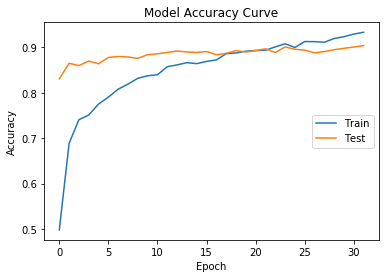

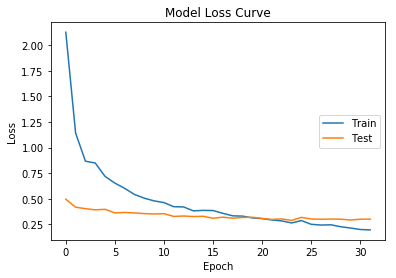

In [7]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Model Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

In [8]:
model_c_mid_layer = Model(
    inputs=model_c.inputs,
    outputs=model_c.get_layer(mid_layer_name).output
)

def mid_l_predict(feature):
    predict = model_c_mid_layer.predict(np.asarray([feature]))[0]
    return predict

reco_predicts = []
reco_label = []
reco_img = []

for x_t, y_t in tqdm(list(zip(x_test, y_test))[:5000]):
    fe = feature_extract(x_t)
    reco_predicts.append(mid_l_predict(fe))
    reco_label.append(y_t)
    reco_img.append(x_t)

scaler = StandardScaler()
reco_predicts = scaler.fit_transform(reco_predicts)

100%|██████████| 5000/5000 [01:54<00:00, 43.83it/s]


In [9]:
test_idx = 5033

fe = feature_extract(x_test[test_idx])
predict_class = model_c.predict_classes(np.asarray([fe]))
predict_mid = mid_l_predict(fe)
predict_mid = scaler.transform([predict_mid])[0]

dists = [(i, distance.euclidean(reco_predicts[i], predict_mid)) for i in range(len(reco_predicts))]
dists.sort(key=lambda x: x[1])
dists = dists[:6]
dists_idxs = [d[0] for d in dists]

Test Item: #5033
Label Class: 9
Predict Class: 9


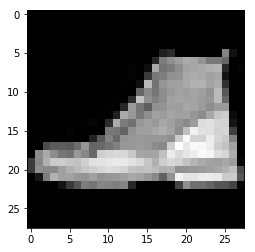

Recommended Results: #[3317, 2405, 3785, 3184, 3786, 1017]
Classes: #[9, 9, 9, 9, 9, 9]


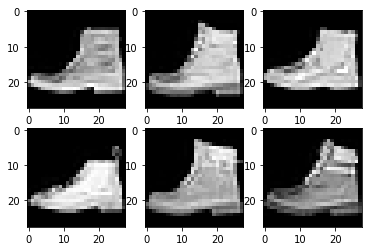

In [10]:
print('Test Item: #{}'.format(test_idx))
print('Label Class: {}\nPredict Class: {}'.format(
    y_test[test_idx],
    predict_class[0]
))

plt.imshow(x_test[test_idx], cmap=plt.get_cmap('gray'))
plt.show()

print('Recommended Results: #{}'.format(dists_idxs))
print('Classes: #{}'.format([reco_label[i] for i in dists_idxs]))

for index, item_index in enumerate(dists_idxs):
    plt.subplot(230+(index+1))
    plt.imshow(reco_img[dists_idxs[index]], cmap=plt.get_cmap('gray'))
plt.show()